In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [25]:
ames_data = pd.read_csv("train.csv")

ames_data.columns = ames_data.columns.map(lambda x: str(x.replace(' ', '_')))
ames_data.columns

Index(['Id', 'PID', 'MS_SubClass', 'MS_Zoning', 'Lot_Frontage', 'Lot_Area',
       'Street', 'Alley', 'Lot_Shape', 'Land_Contour', 'Utilities',
       'Lot_Config', 'Land_Slope', 'Neighborhood', 'Condition_1',
       'Condition_2', 'Bldg_Type', 'House_Style', 'Overall_Qual',
       'Overall_Cond', 'Year_Built', 'Year_Remod/Add', 'Roof_Style',
       'Roof_Matl', 'Exterior_1st', 'Exterior_2nd', 'Mas_Vnr_Type',
       'Mas_Vnr_Area', 'Exter_Qual', 'Exter_Cond', 'Foundation', 'Bsmt_Qual',
       'Bsmt_Cond', 'Bsmt_Exposure', 'BsmtFin_Type_1', 'BsmtFin_SF_1',
       'BsmtFin_Type_2', 'BsmtFin_SF_2', 'Bsmt_Unf_SF', 'Total_Bsmt_SF',
       'Heating', 'Heating_QC', 'Central_Air', 'Electrical', '1st_Flr_SF',
       '2nd_Flr_SF', 'Low_Qual_Fin_SF', 'Gr_Liv_Area', 'Bsmt_Full_Bath',
       'Bsmt_Half_Bath', 'Full_Bath', 'Half_Bath', 'Bedroom_AbvGr',
       'Kitchen_AbvGr', 'Kitchen_Qual', 'TotRms_AbvGrd', 'Functional',
       'Fireplaces', 'Fireplace_Qu', 'Garage_Type', 'Garage_Yr_Blt',
       'G

In [26]:
ames_data['SalePrice'].describe()

count      2051.000000
mean     181469.701609
std       79258.659352
min       12789.000000
25%      129825.000000
50%      162500.000000
75%      214000.000000
max      611657.000000
Name: SalePrice, dtype: float64

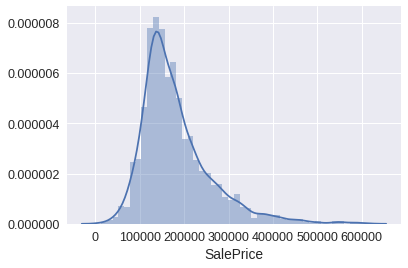

In [27]:
sns.distplot(ames_data['SalePrice']);

In [28]:
print("Skewness: %f" % ames_data['SalePrice'].skew())
print("Kurtosis: %f" % ames_data['SalePrice'].kurt())

Skewness: 1.557551
Kurtosis: 3.579003


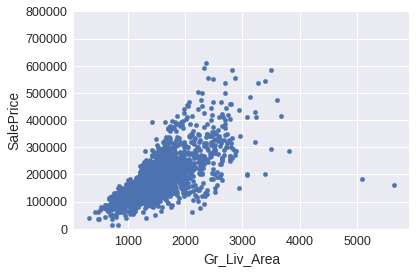

In [29]:
var = 'Gr_Liv_Area'
data = pd.concat([ames_data['SalePrice'], ames_data[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000));

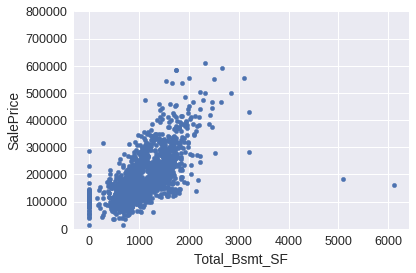

In [30]:
var = 'Total_Bsmt_SF'
data = pd.concat([ames_data['SalePrice'], ames_data[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000));

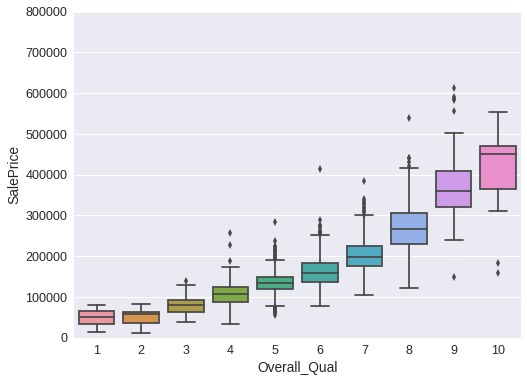

In [31]:
var = 'Overall_Qual'
data = pd.concat([ames_data['SalePrice'], ames_data[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000);

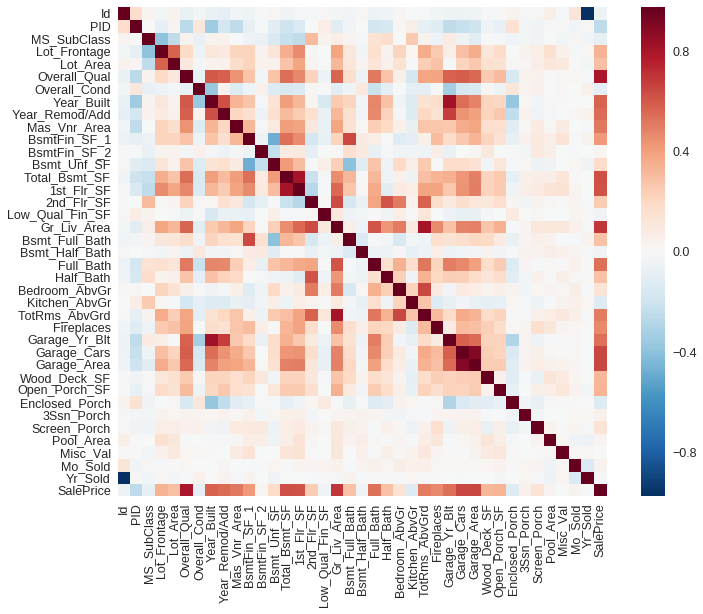

In [32]:
corrmat = ames_data.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

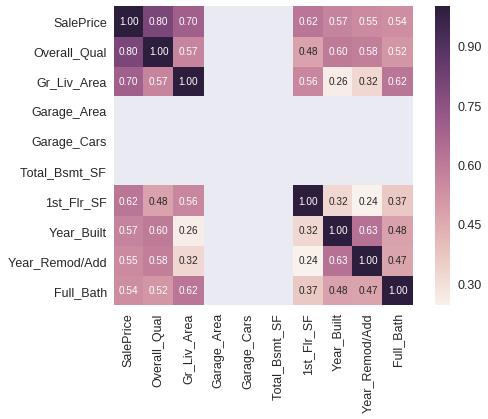

In [33]:
k = 10 #number of variables for heatmap
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(ames_data[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

#  Moving on to missing data.

In [34]:
total = ames_data.isnull().sum().sort_values(ascending=False)
percent = (ames_data.isnull().sum()/ames_data.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
Pool_QC,2042,0.995612
Misc_Feature,1986,0.968308
Alley,1911,0.931741
Fence,1651,0.804973
Fireplace_Qu,1000,0.487567
Lot_Frontage,330,0.160897
Garage_Cond,114,0.055583
Garage_Finish,114,0.055583
Garage_Yr_Blt,114,0.055583
Garage_Qual,114,0.055583


In [35]:
#dealing with missing data
ames_data = ames_data.drop((missing_data[missing_data['Total'] > 1]).index,1)
ames_data = ames_data.drop(ames_data.loc[ames_data['Electrical'].isnull()].index)
ames_data.isnull().sum().max()

1

In [36]:
ames_data['SalePrice'] = np.log(ames_data['SalePrice'])
ames_data['Gr_Liv_Area'] = np.log(ames_data['Gr_Liv_Area'])


In [37]:
ames_data['HasBsmt'] = pd.Series(len(ames_data['Total_Bsmt_SF']), index=ames_data.index)
ames_data['HasBsmt'] = 0 
ames_data.loc[ames_data['Total_Bsmt_SF']>0,'HasBsmt'] = 1

In [38]:
ames_data.loc[ames_data['HasBsmt']==1,'Total_Bsmt_SF'] = np.log(ames_data['Total_Bsmt_SF'])

In [39]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet, LassoCV, RidgeCV, ElasticNetCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, FunctionTransformer, Imputer
import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn

In [41]:
from scipy import stats

In [44]:
y = np.log(ames_data['SalePrice'])

#X = boxcox(['Gr_Liv_Area', 'Total_Bsmt_SF'])

#X = stats.boxcox('Gr_Liv_Area')

X = ["Overall_Qual", '1st_Flr_SF']

X = stats.boxcox(X)

TypeError: '<=' not supported between instances of 'numpy.ndarray' and 'int'

In [19]:
#X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)